In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(color_codes=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.10.0


## Load the data

In [3]:
df = pd.read_csv('../cleaned_data/ISAT.csv', index_col='Date', parse_dates=True)
df.head()

,7 DAYS MA,14 DAYS MA,21 DAYS MA,7 DAYS STD DEV,RSI 7,RSI 14,RSI 21,MFI 7,MFI 14,MFI 21,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,Close
Date,,,,,,,,,,,,,,,,,,
2012-10-17,0.759710,0.604458,0.595933,0.242258,1.073993,0.336948,0.195283,0.418518,1.067216,0.074403,0.008923,1.34241,1.016593,-1.845348,1.033444,0.147246,1.030312,0.865115
2012-10-18,0.799685,0.635721,0.597431,-0.312385,0.806786,0.206638,0.098052,0.304528,0.918634,0.133079,0.716706,1.34241,1.016593,-1.845348,1.042927,0.261864,1.030312,0.834181
2012-10-19,0.808568,0.664751,0.597431,-0.297827,0.806786,0.206638,0.098052,-0.471880,0.973428,0.288599,1.424489,1.34241,1.016593,-1.845348,1.052410,0.376483,1.030312,0.834181
2012-10-22,0.804127,0.700480,0.607911,-0.381060,1.262253,0.576726,0.392023,0.072030,0.933544,0.944165,-1.406643,1.34241,1.016593,-1.845348,1.080859,0.720337,1.096678,0.926983
2012-10-23,0.821893,0.736209,0.633364,-0.038690,0.946168,0.427620,0.284938,0.419894,0.917644,1.321251,-0.698860,1.34241,1.016593,-1.845348,1.090342,0.834955,1.096678,0.896049


### Plot the Close price - our target

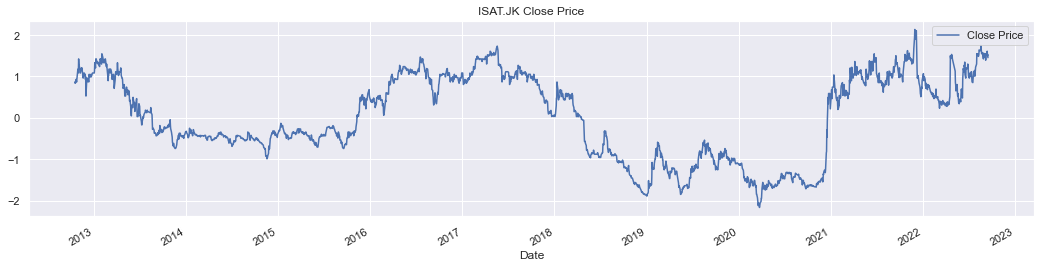

In [4]:
df['Close'].plot(figsize=(18, 4))
plt.legend(['Close Price'])
plt.title('ISAT.JK Close Price')
plt.show()

### Split the data
- Split the data into independent variables and target variable
- Split the data into train and test set (80:20)

In [5]:
train_len = int(len(df)*.8)
train_dataset = df[:train_len]
test_dataset = df[train_len:len(df)]

In [6]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Close')
test_labels = test_features.pop('Close')

## Modeling

### Regression with Deep Neural Network

In [7]:
from utils import build_and_compile_model, fit_model

In [8]:
from utils import genPredictions, inversePredsAndAct, evaluateModel

In [9]:
from joblib import load

close_scaler = load('../feature_engineering/isat_close_scaler.bin')

In [10]:
epochs_cands = [100,150,200]
batch_size_cands = [32,64,128]
performances = {}
models = {}
predictions_dfs = {}
inversed_dfs = {}

modelID = 1
for epochs in epochs_cands:
    for batch_size in batch_size_cands:
        print(f'\n==========MODEL {modelID} with epochs: {epochs} and batch size: {batch_size}==========')
        model = build_and_compile_model(17)
        history = fit_model(model, epochs, batch_size, train_features, train_labels)
        models[f'Model-{modelID}'] = (model, history)
        predictions = genPredictions(model, df, test_features, train_len)
        predictions_dfs[f'Model-{modelID}'] = predictions
        
        inversed = inversePredsAndAct(predictions, close_scaler, test_labels)
        inversed_dfs[f'Model-{modelID}'] = inversed
        rmse_, mape_, rsquared_ = evaluateModel(inversed)
        performances[f'Model-{modelID}'] = {
            'Epochs': epochs,
            'Batch Size': batch_size,
            'RMSE': rmse_,
            'MAPE': mape_,
            'R2': rsquared_
        }
        
        modelID += 1
        


==========MODEL 1 with epochs: 100 and batch size: 32==========
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 2ms/step

==========MODEL 2 with epochs: 100 and batch size: 64==========
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape 

Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None
16/16 [==============================] - 0s 2ms/step


In [11]:
performance_df = pd.DataFrame(performances).transpose()
performance_df[['Epochs', 'Batch Size']] = performance_df[['Epochs', 'Batch Size']].astype(int)
performance_df.head(9)

,Epochs,Batch Size,RMSE,MAPE,R2
Model-1,100,32,288.288753,3.641453,0.963265
Model-2,100,64,226.206537,3.227774,0.977383
Model-3,100,128,246.985174,4.072703,0.973037
Model-4,150,32,288.801088,4.241880,0.963134
Model-5,150,64,351.169195,4.562235,0.945492
Model-6,150,128,237.377434,3.304527,0.975094
Model-7,200,32,250.240948,3.880693,0.972321
Model-8,200,64,326.443502,4.934624,0.952897
Model-9,200,128,267.207615,3.519279,0.968441


### Plot the best model

In [12]:
from utils import plotPredAct, plotErrorHist

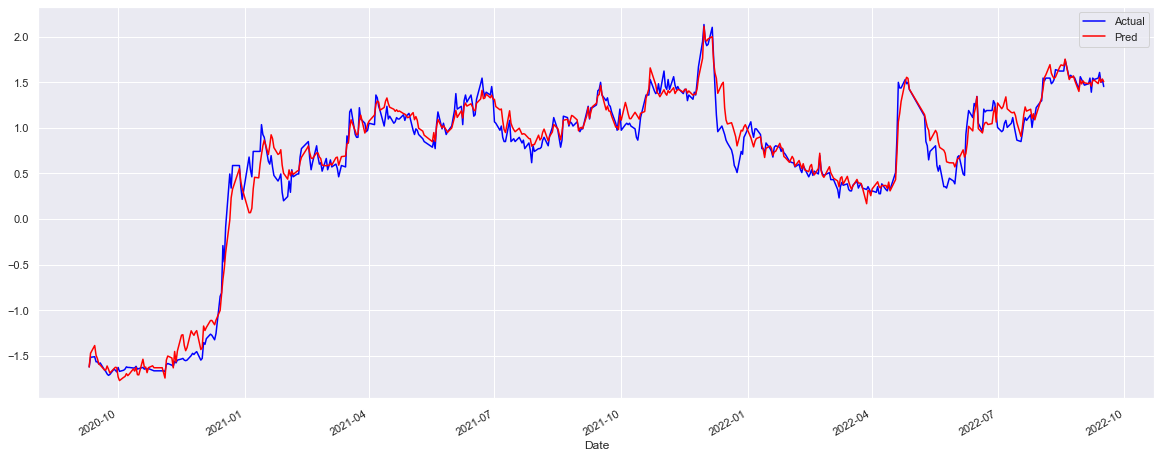

In [13]:
plotPredAct(predictions_dfs['Model-2'])

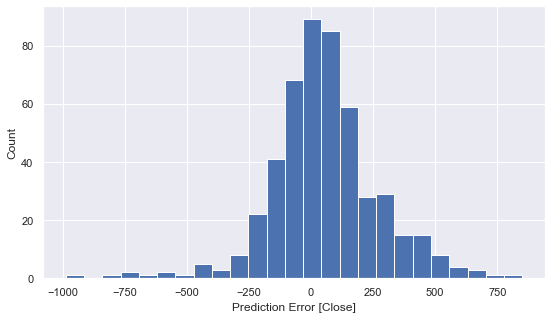

In [14]:
plt.figure(figsize=(9,5))
plotErrorHist(inversed_dfs['Model-2'])

### Save the best model

In [15]:
models['Model-2'][0].save('./models/isat.h5')

In [16]:
loadedModel = keras.models.load_model('./models/isat.h5')

In [17]:
loadedModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1152      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
